In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [5]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation, data splitting, and vectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Word embeddings and NLP models
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [9]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


#### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [10]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [11]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [12]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [13]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [14]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
  #  lemmatizer = WordNetLemmatizer()
  #  stop_words = set(stopwords.words('english'))
  #  column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [15]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [16]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


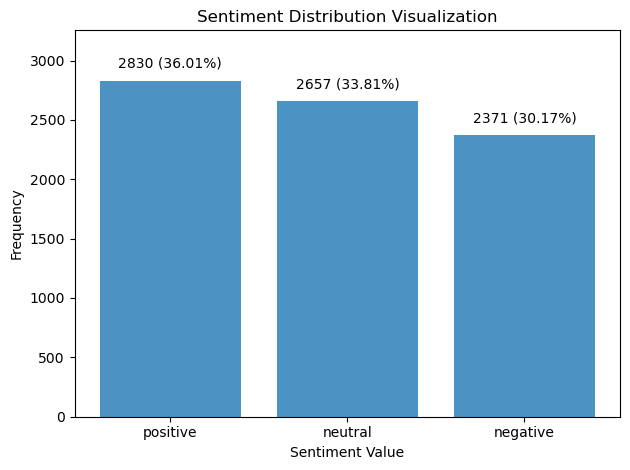

In [17]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

### SVM Implementation

In [18]:
def compute_specificity_and_fpr(confusion_matrix):
    """
    Compute specificity, false positive rate (FPR), weighted average, and macro average for a multi-class confusion matrix.
    
    Parameters:
    - confusion_matrix (numpy.ndarray): A square 2D numpy array representing the confusion matrix. Rows represent the true labels and columns represent predicted labels.
    
    Returns:
    - specificities (list): A list containing the specificity for each class.
    - fprs (list): A list containing the false positive rate for each class.
    - weighted_avg_spec (float): The weighted average specificity across all classes.
    - weighted_avg_fpr (float): The weighted average false positive rate across all classes.
    - macro_avg_spec (float): The macro average specificity across all classes.
    - macro_avg_fpr (float): The macro average false positive rate across all classes.
    """   
    num_classes = confusion_matrix.shape[0]
    specificities = []
    fprs = []
    
    true_values = np.sum(confusion_matrix, axis=1)
    total_true_values = np.sum(true_values)
    
    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i)
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        
        specificities.append(specificity)
        fprs.append(fpr)
    
    weighted_avg_spec = sum(specificities[i] * true_values[i] for i in range(num_classes)) / total_true_values
    weighted_avg_fpr = sum(fprs[i] * true_values[i] for i in range(num_classes)) / total_true_values
    
    macro_avg_spec = sum(specificities) / num_classes
    macro_avg_fpr = sum(fprs) / num_classes

    return specificities, fprs, weighted_avg_spec, weighted_avg_fpr, macro_avg_spec, macro_avg_fpr


In [20]:
def plt_confusion_matrix(true_labels, predicted_labels, set_name="Data"):
    """
    Plots a confusion matrix using seaborn and displays metrics

    Parameters:
    - true_labels (list or array): Actual labels of the data.
    - predicted_labels (list or array): Predicted labels from a model.
    - set_name (str, optional): A string name for the data set. Default is "Data".

    Returns:
    None. Displays the confusion matrix plot.
    
    Note:
    The function assumes three classes: 'positive', 'negative', and 'neutral' and has them hardcoded for ordering.
    """
    order_map = {0: 'positive', 1: 'negative', 2: 'neutral'}
    unique_numeric_labels = sorted(list(set(true_labels)))
    unique_string_labels = [order_map[label] for label in unique_numeric_labels]
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=unique_numeric_labels)
    specificities, fprs, weighted_avg_spec, weighted_avg_fpr, macro_avg_spec, macro_avg_fpr  = compute_specificity_and_fpr(cm)
    
    print("\nSpecificity per class:")
    for i, label in enumerate(unique_string_labels):
        print(f"{label}: {specificities[i]:.4f}")
        
    print("\nFalse Positive Rate (FPR) per class:")
    for i, label in enumerate(unique_string_labels):
        print(f"{label}: {fprs[i]:.4f}")
    
    print(f"\nWeighted average specificity: {weighted_avg_spec:.4f}")
    print(f"Weighted average FPR: {weighted_avg_fpr:.4f}")
    print(f"\nMacro average specificity: {macro_avg_spec:.4f}")
    print(f"Macro average FPR: {macro_avg_fpr:.4f}")
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [21]:
def display_sentences(X, y_true, y_pred, num_samples=5):
    """
    Print a number of misclassified samples.

    Parameters:
    - X: The original text data (e.g., sentences).
    - y_true: True labels.
    - y_pred: Predicted labels by the model.
    - num_samples: Number of misclassified samples to print for each category.

    Returns:
    None. Prints the misclassified samples.
    """
    misclassified_indices = np.where(y_true != y_pred)[0]
    order_map = {0: 'positive', 1: 'negative', 2: 'neutral'}

    for label_num, label_str in order_map.items():
        print(f"Misclassified as {label_str}:\n")
        count = 0
        for index in misclassified_indices:
            if y_pred[index] == label_num:
                print(f"True: {order_map[y_true[index]]}, Predicted: {label_str}, Text: {X.iloc[index]}")
                count += 1
                if count == num_samples:
                    break
        print("\n")

In [22]:
def train_svm_with_gridsearch(kernel_type, X_train_vec, y_train, X_val_vec, y_val, X_test_original ,X_test_vec, y_test):
    """
    Train and evaluate an SVM model with the given kernel type using GridSearchCV for hyperparameter tuning.
    
    Parameters:
    - kernel_type (str): The kernel type for the SVM. It can be 'linear', 'rbf', or 'poly'.
    - X_train_vec, y_train: Training data and their corresponding labels.
    - X_val_vec, y_val: Validation data and their corresponding labels.
    - X_test_vec, y_test: Test data and their corresponding labels.
    
    Returns:
    None. The function will print classification reports for training, validation, and test datasets.
    """
    
    parameters = {
          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    }

    # Only add 'gamma' for 'rbf' and 'poly' kernels
    if kernel_type in ['rbf', 'poly']:
        parameters['gamma'] = ['scale', 'auto']
    
    # SVM with GridSearchCV
    svm = SVC(kernel=kernel_type)
    clf = GridSearchCV(svm, parameters, cv=5)  # 5-fold cross-validation
    clf.fit(X_train_vec, y_train)

    # Use best estimator from GridSearchCV to make predictions
    y_train_pred = clf.best_estimator_.predict(X_train_vec)
    y_val_pred = clf.best_estimator_.predict(X_val_vec)
    y_test_pred = clf.best_estimator_.predict(X_test_vec)

    # Evaluating the model
    print(f"SVM Model with {kernel_type} kernel (Best Parameters: {clf.best_params_}):")
    print("\nTraining Metrics:")
    print(classification_report(y_train, y_train_pred, digits= 4))

    print("\nValidation Metrics:")
    print(classification_report(y_val, y_val_pred, digits= 4))
    plt_confusion_matrix(y_val, y_val_pred, "Validation")

    print("\nTest Metrics:")
    print(classification_report(y_test, y_test_pred, digits= 4))
    plt_confusion_matrix(y_test, y_test_pred, "Test")
    
    print("\nMisclassified Samples (Test Set):\n")
    display_sentences(X_test_original, y_test, y_test_pred)


In [23]:
def split_data(X, y):
    """
    Splits the dataset into training, validation, and test sets.

    Parameters:
    - X: Features.
    - y: Targets/Labels.

    Returns:
    - X_train, X_val, X_test: Training, validation, and test sets for features.
    - y_train, y_val, y_test: Training, validation, and test sets for targets/labels.
    """
    
    # splitting the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)
    
    # Resetting the indices
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [24]:
def vectorize_data(X_train, X_val, X_test, max_features, ngram_range, min_df, max_df):
    """
    Vectorizes the text data using TF-IDF.

    Parameters:
    - X_train, X_val, X_test: Training, validation, and test sets for features.
    - max_features: The maximum number of features (vocabulary size).
    - ngram_range: The range of n-gram.
    - min_df: Minimum document frequency.
    - max_df: Maximum document frequency.

    Returns:
    - X_train_vec, X_val_vec, X_test_vec: Vectorized training, validation, and test data.
    """
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features, ngram_range=ngram_range, min_df=min_df, max_df=max_df)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_val_vec, X_test_vec

In [25]:
#!pip install wget

In [26]:
'''import wget
import zipfile

# Downloading the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"
wget.download(url, "glove.6B.zip")

# Unzipping the downloaded file
with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
'''

'import wget\nimport zipfile\n\n# Downloading the GloVe embeddings\nurl = "http://nlp.stanford.edu/data/glove.6B.zip"\nwget.download(url, "glove.6B.zip")\n\n# Unzipping the downloaded file\nwith zipfile.ZipFile("glove.6B.zip", \'r\') as zip_ref:\n    zip_ref.extractall(".")\n'

In [27]:
def load_glove_model(glove_input_file, word2vec_output_file):
    """
    Convert GloVe embeddings to word2vec format and load them using gensim.
    
    Parameters:
    - glove_input_file (str): Path to the input GloVe embeddings.
    - word2vec_output_file (str): Path to the converted word2vec formatted file.

    Returns:
    - gensim.models.KeyedVectors: Loaded word2vec formatted embeddings.
    """
    
    # Convert GloVe file to word2vec format
    glove2word2vec(glove_input_file, word2vec_output_file)
    
    # Load the word2vec format file using gensim
    return gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def vectorize_with_glove(X, glove_model):
    """
    Convert a list of text sentences into their averaged GloVe vector representations.

    Parameters:
    - X (list of str): List of text sentences.
    - glove_model (gensim.models.KeyedVectors): Loaded GloVe model using gensim.

    Returns:
    - np.array: An array of averaged GloVe vectors representing the input text.
    """
    
    embedding_matrix = []
    for text in X:
        # Retrieve GloVe vectors for each word in the text, then average them
        # Words not present in the GloVe model will be ignored
        vector = np.mean([glove_model[word] for word in text.split() if word in glove_model], axis=0)
        
        # If no word from the text is in the GloVe model, the result is a NaN float
        # In such cases, we use a zero vector as a default representation
        if isinstance(vector, float):
            vector = np.zeros(glove_model.vector_size)
        embedding_matrix.append(vector)
    return np.array(embedding_matrix)

glove_file = "glove.6B.50d.txt"
word2vec_output_file = "glove.6B.50d.txt.word2vec"

# Load the GloVe model into memory
glove_model = load_glove_model(glove_file, word2vec_output_file)

/var/folders/_4/gqsgcp1j0kx8p_ctzh3ddsmm0000gn/T/ipykernel_22647/3466537511.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [28]:
# --- Data Preparation ---

# Map the sentiments to numerical values
target_map = {'neutral':2,'positive':0,'negative':1}
processed_df = processed_df.copy()
processed_df.loc[:, 'Target'] = processed_df['Sentiment'].map(target_map)
processed_df.head()

,Headlines,Sentiment,Target
0,spicejet to issue 64 crore warrants to promoters,neutral,2
1,mmtc q2 net loss at rs 104 crore,neutral,2
2,midcap funds can deliver more stay put experts,positive,0
3,mid caps now turn into market darlings,positive,0
4,market seeing patience if not conviction praka...,neutral,2


SVM Model with linear kernel (Best Parameters: {'C': 1}):

Training Metrics:
              precision    recall  f1-score   support

           0     0.6870    0.6482    0.6670      1981
           1     0.7315    0.4815    0.5807      1647
           2     0.6086    0.8280    0.7015      1872

    accuracy                         0.6595      5500
   macro avg     0.6757    0.6525    0.6498      5500
weighted avg     0.6736    0.6595    0.6529      5500


Validation Metrics:
              precision    recall  f1-score   support

           0     0.6396    0.6117    0.6253       412
           1     0.7295    0.4798    0.5789       371
           2     0.5545    0.7576    0.6403       396

    accuracy                         0.6192      1179
   macro avg     0.6412    0.6163    0.6148      1179
weighted avg     0.6393    0.6192    0.6157      1179


Specificity per class:
positive: 0.7710
negative: 0.8932
neutral: 0.6408

False Positive Rate (FPR) per class:
positive: 0.2290
negative: 0

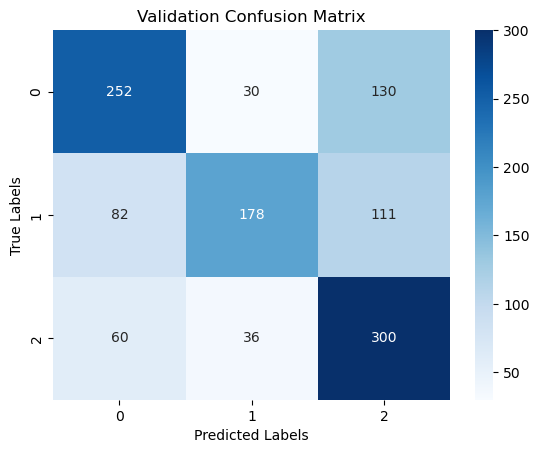


Test Metrics:
              precision    recall  f1-score   support

           0     0.6414    0.5812    0.6098       437
           1     0.7273    0.4759    0.5753       353
           2     0.5688    0.8072    0.6674       389

    accuracy                         0.6243      1179
   macro avg     0.6458    0.6215    0.6175      1179
weighted avg     0.6432    0.6243    0.6185      1179


Specificity per class:
positive: 0.7724
negative: 0.9002
neutral: 0.6394

False Positive Rate (FPR) per class:
positive: 0.2276
negative: 0.0998
neutral: 0.3606

Weighted average specificity: 0.7668
Weighted average FPR: 0.2332

Macro average specificity: 0.7707
Macro average FPR: 0.2293


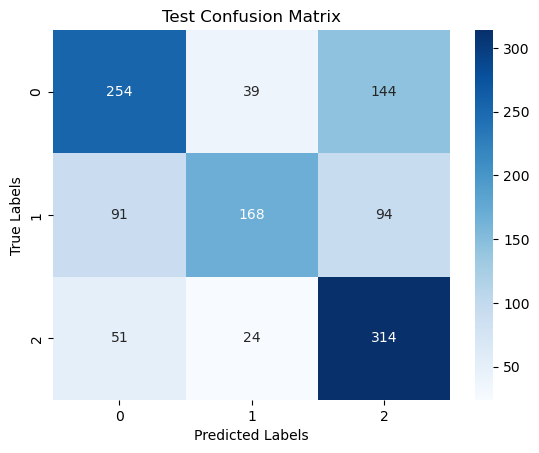


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

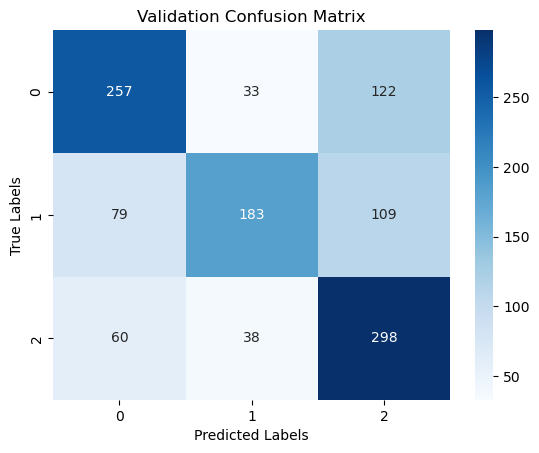


Test Metrics:
              precision    recall  f1-score   support

           0     0.6468    0.5950    0.6198       437
           1     0.7522    0.4816    0.5872       353
           2     0.5771    0.8175    0.6766       389

    accuracy                         0.6344      1179
   macro avg     0.6587    0.6313    0.6279      1179
weighted avg     0.6554    0.6344    0.6288      1179


Specificity per class:
positive: 0.7746
negative: 0.9117
neutral: 0.6486

False Positive Rate (FPR) per class:
positive: 0.2254
negative: 0.0883
neutral: 0.3514

Weighted average specificity: 0.7741
Weighted average FPR: 0.2259

Macro average specificity: 0.7783
Macro average FPR: 0.2217


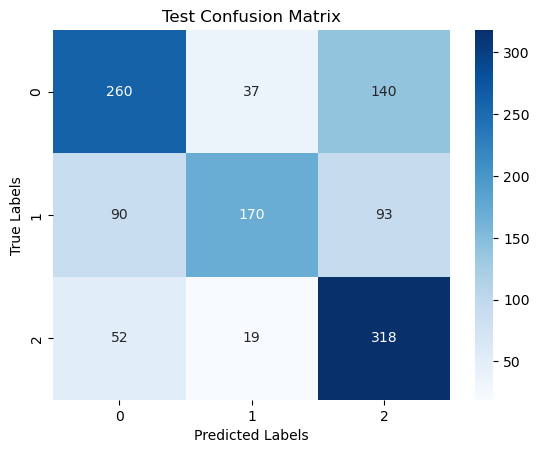


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

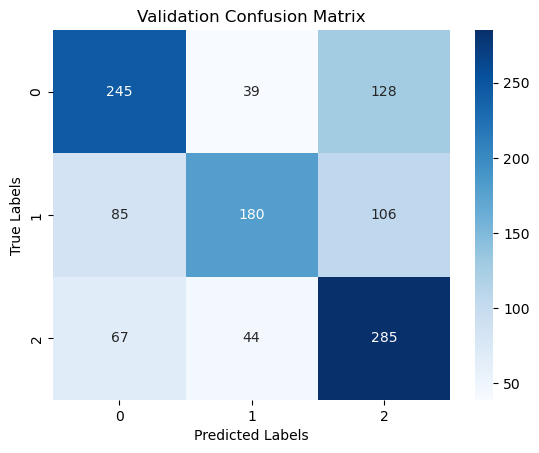


Test Metrics:
              precision    recall  f1-score   support

           0     0.6450    0.5904    0.6165       437
           1     0.7067    0.4504    0.5502       353
           2     0.5650    0.8046    0.6638       389

    accuracy                         0.6192      1179
   macro avg     0.6389    0.6151    0.6102      1179
weighted avg     0.6371    0.6192    0.6123      1179


Specificity per class:
positive: 0.7687
negative: 0.8964
neutral: 0.6337

False Positive Rate (FPR) per class:
positive: 0.2313
negative: 0.1036
neutral: 0.3663

Weighted average specificity: 0.7624
Weighted average FPR: 0.2376

Macro average specificity: 0.7663
Macro average FPR: 0.2337


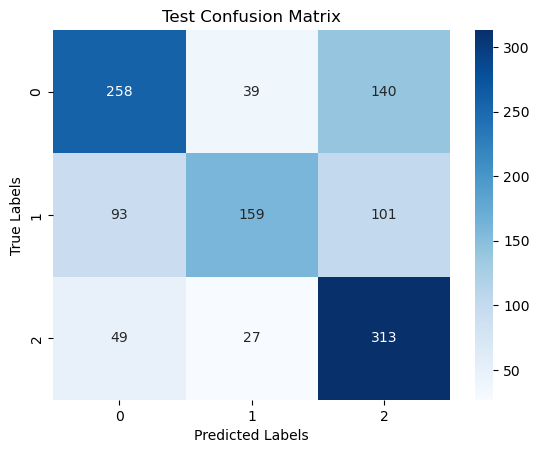


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: rail stocks plunge upto 20 for second day in a row


Misclassified as negative:

True: neutral, Predicted: negative, Text: whats stopping rupee from appreciating beyond 60
True: neutral, Predicted: negative, Text: dlf has become extremely flat ashwani gujral
True: neutral, Predicted: negative, Text: five reasons why rupee may not appreciate much
True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: tight supply lifts mentha oi

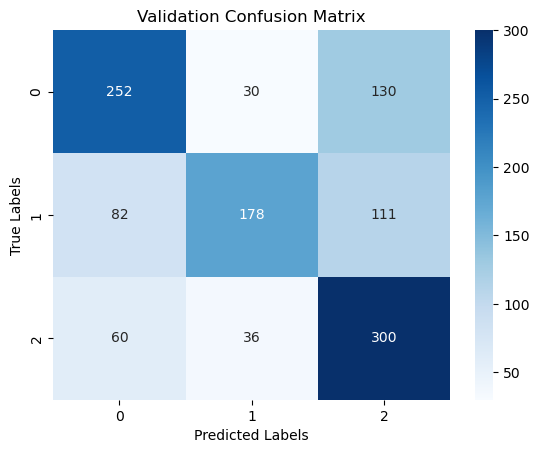


Test Metrics:
              precision    recall  f1-score   support

           0     0.6414    0.5812    0.6098       437
           1     0.7273    0.4759    0.5753       353
           2     0.5688    0.8072    0.6674       389

    accuracy                         0.6243      1179
   macro avg     0.6458    0.6215    0.6175      1179
weighted avg     0.6432    0.6243    0.6185      1179


Specificity per class:
positive: 0.7724
negative: 0.9002
neutral: 0.6394

False Positive Rate (FPR) per class:
positive: 0.2276
negative: 0.0998
neutral: 0.3606

Weighted average specificity: 0.7668
Weighted average FPR: 0.2332

Macro average specificity: 0.7707
Macro average FPR: 0.2293


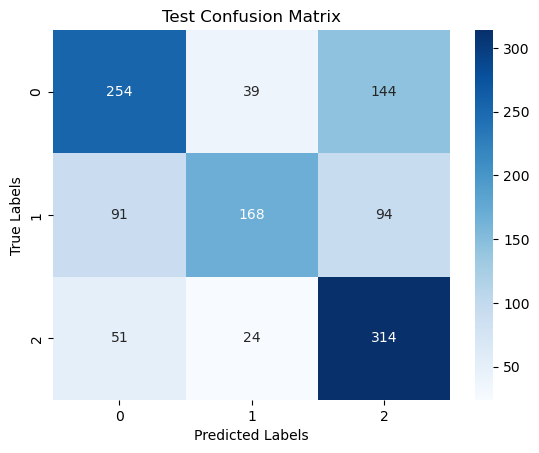


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

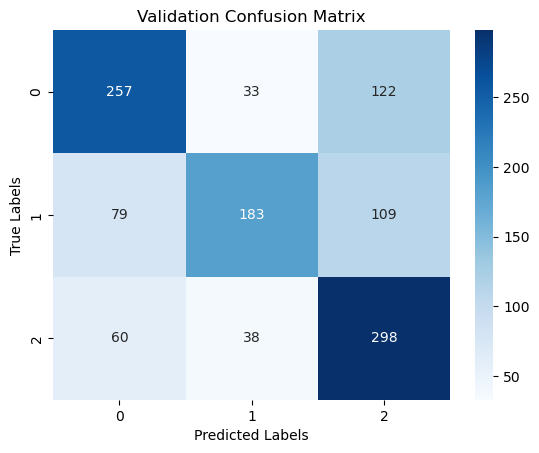


Test Metrics:
              precision    recall  f1-score   support

           0     0.6468    0.5950    0.6198       437
           1     0.7522    0.4816    0.5872       353
           2     0.5771    0.8175    0.6766       389

    accuracy                         0.6344      1179
   macro avg     0.6587    0.6313    0.6279      1179
weighted avg     0.6554    0.6344    0.6288      1179


Specificity per class:
positive: 0.7746
negative: 0.9117
neutral: 0.6486

False Positive Rate (FPR) per class:
positive: 0.2254
negative: 0.0883
neutral: 0.3514

Weighted average specificity: 0.7741
Weighted average FPR: 0.2259

Macro average specificity: 0.7783
Macro average FPR: 0.2217


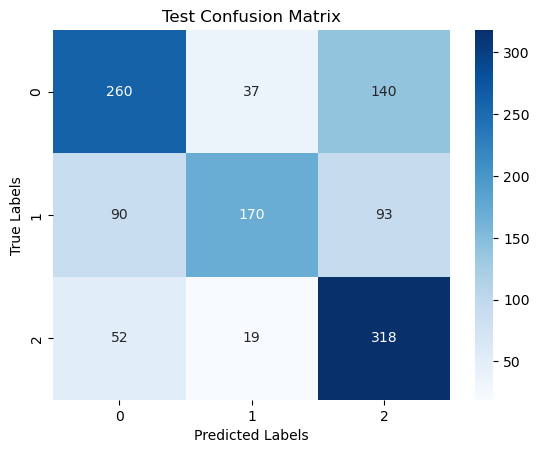


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

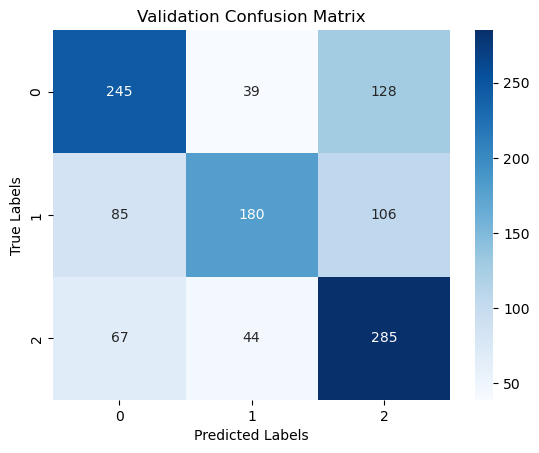


Test Metrics:
              precision    recall  f1-score   support

           0     0.6450    0.5904    0.6165       437
           1     0.7067    0.4504    0.5502       353
           2     0.5650    0.8046    0.6638       389

    accuracy                         0.6192      1179
   macro avg     0.6389    0.6151    0.6102      1179
weighted avg     0.6371    0.6192    0.6123      1179


Specificity per class:
positive: 0.7687
negative: 0.8964
neutral: 0.6337

False Positive Rate (FPR) per class:
positive: 0.2313
negative: 0.1036
neutral: 0.3663

Weighted average specificity: 0.7624
Weighted average FPR: 0.2376

Macro average specificity: 0.7663
Macro average FPR: 0.2337


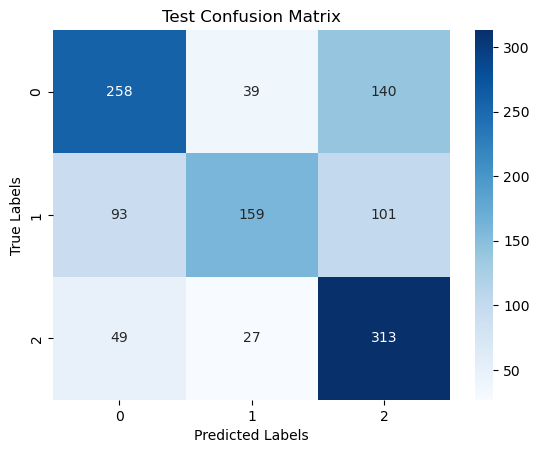


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: rail stocks plunge upto 20 for second day in a row


Misclassified as negative:

True: neutral, Predicted: negative, Text: whats stopping rupee from appreciating beyond 60
True: neutral, Predicted: negative, Text: dlf has become extremely flat ashwani gujral
True: neutral, Predicted: negative, Text: five reasons why rupee may not appreciate much
True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: tight supply lifts mentha oi

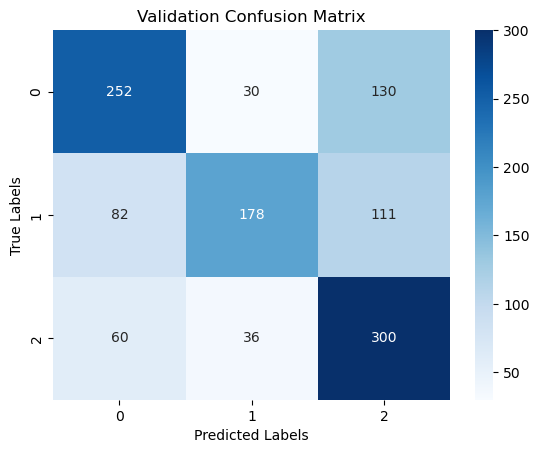


Test Metrics:
              precision    recall  f1-score   support

           0     0.6414    0.5812    0.6098       437
           1     0.7273    0.4759    0.5753       353
           2     0.5688    0.8072    0.6674       389

    accuracy                         0.6243      1179
   macro avg     0.6458    0.6215    0.6175      1179
weighted avg     0.6432    0.6243    0.6185      1179


Specificity per class:
positive: 0.7724
negative: 0.9002
neutral: 0.6394

False Positive Rate (FPR) per class:
positive: 0.2276
negative: 0.0998
neutral: 0.3606

Weighted average specificity: 0.7668
Weighted average FPR: 0.2332

Macro average specificity: 0.7707
Macro average FPR: 0.2293


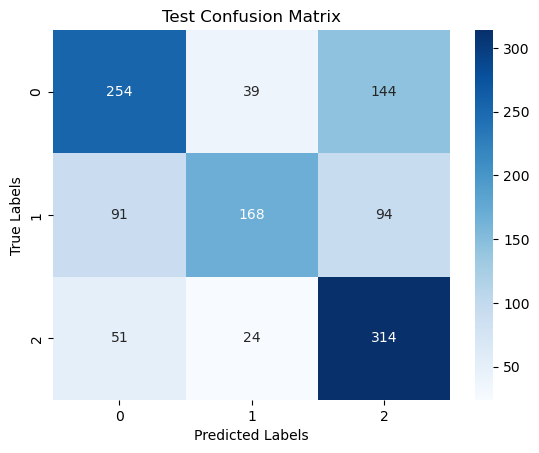


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

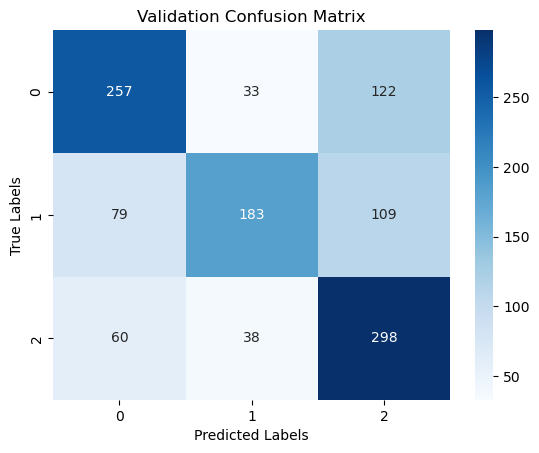


Test Metrics:
              precision    recall  f1-score   support

           0     0.6468    0.5950    0.6198       437
           1     0.7522    0.4816    0.5872       353
           2     0.5771    0.8175    0.6766       389

    accuracy                         0.6344      1179
   macro avg     0.6587    0.6313    0.6279      1179
weighted avg     0.6554    0.6344    0.6288      1179


Specificity per class:
positive: 0.7746
negative: 0.9117
neutral: 0.6486

False Positive Rate (FPR) per class:
positive: 0.2254
negative: 0.0883
neutral: 0.3514

Weighted average specificity: 0.7741
Weighted average FPR: 0.2259

Macro average specificity: 0.7783
Macro average FPR: 0.2217


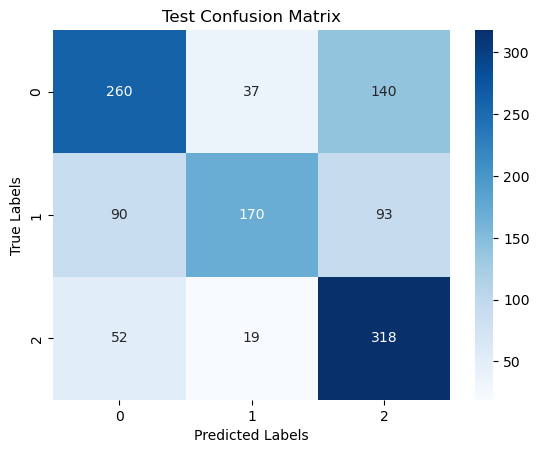


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: avoid bank stocks prateek agarwal ask investment managers


Misclassified as negative:

True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: volkswagen shares bounce back from lows to show gain of 4 in late morning
True: positive, Predicted: negative, Text: tight supply lifts mentha oil futures up 053 per cent
True: positive, Predicted: negative, Text: apple shares top 300 a share for first time
True: positive, Predicted: neg

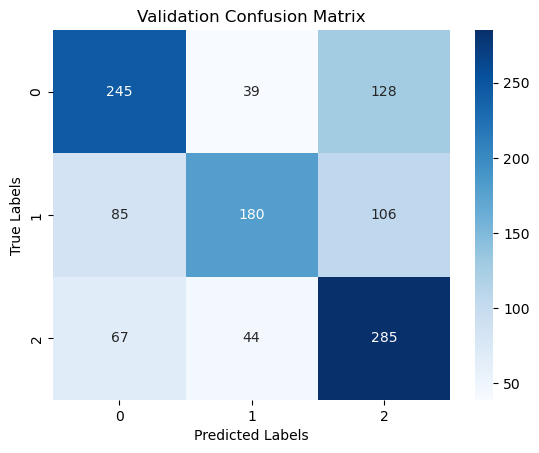


Test Metrics:
              precision    recall  f1-score   support

           0     0.6450    0.5904    0.6165       437
           1     0.7067    0.4504    0.5502       353
           2     0.5650    0.8046    0.6638       389

    accuracy                         0.6192      1179
   macro avg     0.6389    0.6151    0.6102      1179
weighted avg     0.6371    0.6192    0.6123      1179


Specificity per class:
positive: 0.7687
negative: 0.8964
neutral: 0.6337

False Positive Rate (FPR) per class:
positive: 0.2313
negative: 0.1036
neutral: 0.3663

Weighted average specificity: 0.7624
Weighted average FPR: 0.2376

Macro average specificity: 0.7663
Macro average FPR: 0.2337


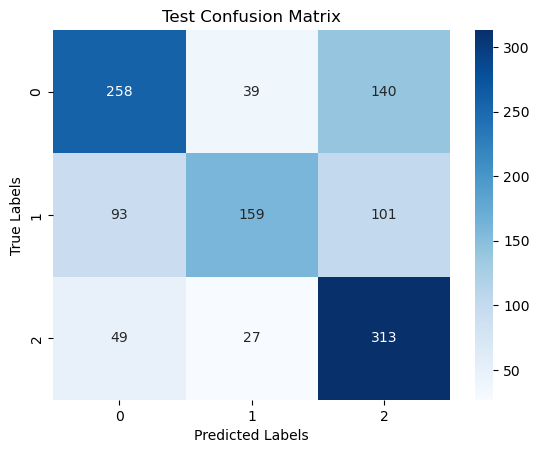


Misclassified Samples (Test Set):

Misclassified as positive:

True: negative, Predicted: positive, Text: auto stocks under pressure as october sales disappoint
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: hul shares down over 3 post q4 earnings
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12
True: negative, Predicted: positive, Text: rail stocks plunge upto 20 for second day in a row


Misclassified as negative:

True: neutral, Predicted: negative, Text: whats stopping rupee from appreciating beyond 60
True: neutral, Predicted: negative, Text: dlf has become extremely flat ashwani gujral
True: neutral, Predicted: negative, Text: five reasons why rupee may not appreciate much
True: positive, Predicted: negative, Text: steady demand rain woes push up guar prices
True: positive, Predicted: negative, Text: tight supply lifts mentha oi

In [29]:
# Main Execution
X = processed_df['Headlines']
y = processed_df['Target']
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

#TFIDF Vectorizing
max_features_list = [1000, 5000, 10000]
kernels = ['linear', 'rbf', 'poly']

for max_features in max_features_list:
    print(max_features)
    X_train_vec, X_val_vec, X_test_vec = vectorize_data(X_train, X_val, X_test, max_features=max_features, ngram_range=(1,3), min_df=0.01, max_df=0.90)
    for kernel in kernels:
        train_svm_with_gridsearch(kernel, X_train_vec, y_train, X_val_vec, y_val, X_test, X_test_vec, y_test)


SVM Model with linear kernel (Best Parameters: {'C': 1000}):

Training Metrics:
              precision    recall  f1-score   support

           0     0.6089    0.6320    0.6203      1981
           1     0.6307    0.5507    0.5880      1647
           2     0.6655    0.7131    0.6885      1872

    accuracy                         0.6353      5500
   macro avg     0.6351    0.6319    0.6323      5500
weighted avg     0.6347    0.6353    0.6338      5500


Validation Metrics:
              precision    recall  f1-score   support

           0     0.5470    0.6068    0.5754       412
           1     0.6156    0.4879    0.5444       371
           2     0.5911    0.6389    0.6141       396

    accuracy                         0.5802      1179
   macro avg     0.5846    0.5779    0.5779      1179
weighted avg     0.5834    0.5802    0.5786      1179


Specificity per class:
positive: 0.6771
negative: 0.8166
neutral: 0.7112

False Positive Rate (FPR) per class:
positive: 0.3229
negative

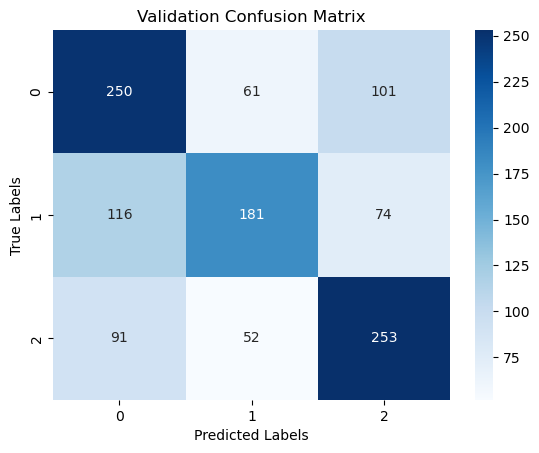


Test Metrics:
              precision    recall  f1-score   support

           0     0.5760    0.5721    0.5741       437
           1     0.6176    0.5354    0.5736       353
           2     0.6310    0.7121    0.6691       389

    accuracy                         0.6073      1179
   macro avg     0.6082    0.6065    0.6056      1179
weighted avg     0.6066    0.6073    0.6053      1179


Specificity per class:
positive: 0.7169
negative: 0.8183
neutral: 0.7304

False Positive Rate (FPR) per class:
positive: 0.2831
negative: 0.1817
neutral: 0.2696

Weighted average specificity: 0.7517
Weighted average FPR: 0.2483

Macro average specificity: 0.7552
Macro average FPR: 0.2448


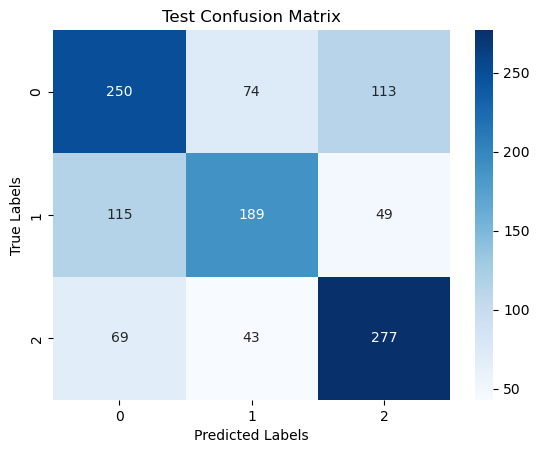


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: micromax hopes to hit market soon with ipo
True: negative, Predicted: positive, Text: european shares edge lower after manufacturing data
True: negative, Predicted: positive, Text: gold steady below 3week top fed meeting eyed
True: negative, Predicted: positive, Text: as copper runs low producers turn ideas to boost output of metal
True: negative, Predicted: positive, Text: unitech q1 dips by 53 pc to rs 4588 crore no dividend for fy12


Misclassified as negative:

True: positive, Predicted: negative, Text: hdfc likely to report 10 growth in q3 net profit
True: positive, Predicted: negative, Text: yum beats q3 profit expectations
True: positive, Predicted: negative, Text: tcs signals slowdown brokerages remain unfazed retain rating
True: positive, Predicted: negative, Text: postive on havells india mitesh thacker
True: neutral, Predicted: negative, Text: whats stopping rupee from a

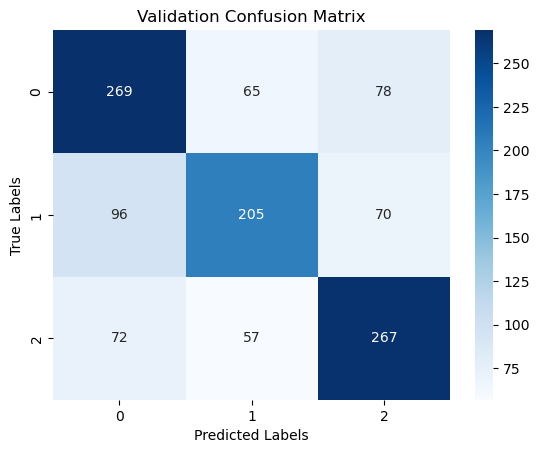


Test Metrics:
              precision    recall  f1-score   support

           0     0.6410    0.6087    0.6244       437
           1     0.6497    0.6147    0.6317       353
           2     0.6721    0.7429    0.7057       389

    accuracy                         0.6548      1179
   macro avg     0.6543    0.6555    0.6540      1179
weighted avg     0.6539    0.6548    0.6534      1179


Specificity per class:
positive: 0.7725
negative: 0.8259
neutral: 0.7740

False Positive Rate (FPR) per class:
positive: 0.2275
negative: 0.1741
neutral: 0.2260

Weighted average specificity: 0.7890
Weighted average FPR: 0.2110

Macro average specificity: 0.7908
Macro average FPR: 0.2092


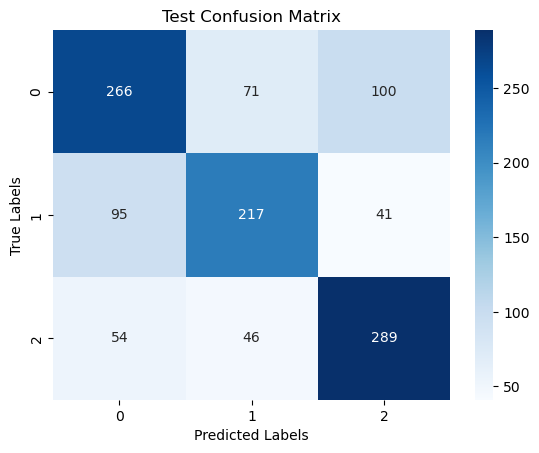


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: micromax hopes to hit market soon with ipo
True: neutral, Predicted: positive, Text: dhunseri petrochem and tea posts q4 pat at rs 2508 crore
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: gold steady below 3week top fed meeting eyed
True: negative, Predicted: positive, Text: as copper runs low producers turn ideas to boost output of metal


Misclassified as negative:

True: neutral, Predicted: negative, Text: union budget 201213 power cos trading mixed on ecb fuel supply decision
True: positive, Predicted: negative, Text: tcs signals slowdown brokerages remain unfazed retain rating
True: positive, Predicted: negative, Text: postive on havells india mitesh thacker
True: neutral, Predicted: negative, Text: whats stopping rupee from appreciating beyond 60
True: neutral, Predicted: negative

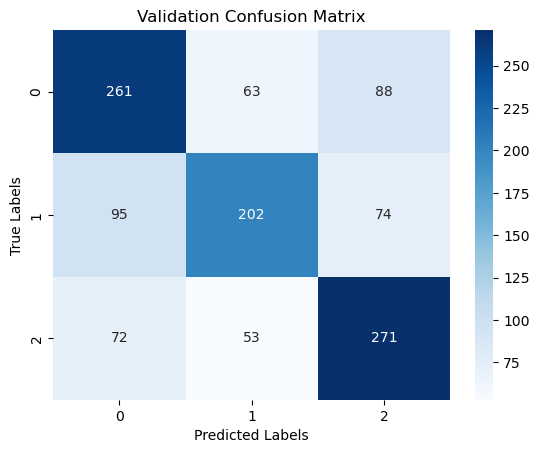


Test Metrics:
              precision    recall  f1-score   support

           0     0.6311    0.6224    0.6267       437
           1     0.6677    0.5921    0.6276       353
           2     0.6713    0.7506    0.7087       389

    accuracy                         0.6556      1179
   macro avg     0.6567    0.6550    0.6544      1179
weighted avg     0.6553    0.6556    0.6541      1179


Specificity per class:
positive: 0.7591
negative: 0.8443
neutral: 0.7708

False Positive Rate (FPR) per class:
positive: 0.2409
negative: 0.1557
neutral: 0.2292

Weighted average specificity: 0.7885
Weighted average FPR: 0.2115

Macro average specificity: 0.7914
Macro average FPR: 0.2086


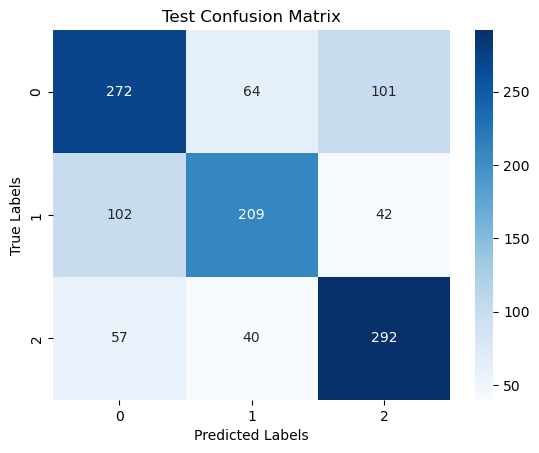


Misclassified Samples (Test Set):

Misclassified as positive:

True: neutral, Predicted: positive, Text: dhunseri petrochem and tea posts q4 pat at rs 2508 crore
True: negative, Predicted: positive, Text: nothing much happening in nucleus software deepak mohini
True: negative, Predicted: positive, Text: european shares edge lower after manufacturing data
True: negative, Predicted: positive, Text: gold steady below 3week top fed meeting eyed
True: negative, Predicted: positive, Text: as copper runs low producers turn ideas to boost output of metal


Misclassified as negative:

True: neutral, Predicted: negative, Text: micromax hopes to hit market soon with ipo
True: neutral, Predicted: negative, Text: union budget 201213 power cos trading mixed on ecb fuel supply decision
True: positive, Predicted: negative, Text: tcs signals slowdown brokerages remain unfazed retain rating
True: neutral, Predicted: negative, Text: dlf has become extremely flat ashwani gujral
True: neutral, Predicted: 

In [30]:
# Vectorize using GloVe embeddings
X_train_vec_glove = vectorize_with_glove(X_train, glove_model)
X_val_vec_glove = vectorize_with_glove(X_val, glove_model)
X_test_vec_glove = vectorize_with_glove(X_test, glove_model)

kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    train_svm_with_gridsearch(kernel, X_train_vec_glove, y_train, X_val_vec_glove, y_val, X_test, X_test_vec_glove, y_test)
